In [1]:
import sys
import os
from ase.build import bulk
from ase.visualize.plot import plot_atoms
from ase.build.surfaces_with_termination import surfaces_with_termination
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(25,10))
import numpy as np
from ase.build import sort
from ase.io.vasp import read_vasp
from ase.build import surface, make_supercell
from ase.build import sort
from ase.geometry import get_layers
import Tools as tl
from ase.visualize import view


# Parámetros 

In [2]:
surfacelocation = 'superficies_febrero2022'
if not os.path.exists(surfacelocation):
    os.makedirs(surfacelocation)
vacuum = 10

# Creo celda ZrO2 2x2 en el plano 1 0 -1 0 y un sitio tipo 'top'

In [3]:
layers_zro2 = 4

In [4]:
zro2 = read_vasp('Structure/POSCAR')

In [5]:
ZrO2001Oterm = surfaces_with_termination(zro2, [0,0,1],layers=4, vacuum=vacuum, termination='O',verbose=True, symmetric=True)

([4], ['Zr']) ([20], ['O'])
([3], ['O']) ([18], ['O'])
([5], ['Zr']) ([21], ['O'])
([2], ['O']) ([19], ['O'])


## Seleccionar que sitio se quiere hacer en ZrO2

### sitio debe ser igual a 'top','hollow1','hollow2','bridge'

In [6]:
ZrO2001Oterm_2x2_unsorted = [make_supercell(thisurface,[[2,0,0],[0,2,0],[0,0,1]],tol=1e-10, wrap=True) for thisurface in ZrO2001Oterm]
ZrO2001Oterm_2x2 = sort(ZrO2001Oterm_2x2_unsorted[0])

sitio = 'bridge' # elegir uno de ['top', 'hollow1', 'hollow2', 'bridge']
              # hay que incluirlo en tools !

layer, height = get_layers(ZrO2001Oterm_2x2, (0,0,1), tolerance=0.7)
h_sitio = ZrO2001Oterm_2x2.positions.max(axis=0)[-1]

if sitio == 'top':
    tl.get_adsite(ZrO2001Oterm_2x2, site='top', face='top')
    ontop = tl.make_adstruc(ZrO2001Oterm_2x2, 'RotBotTop', theface='top', thesite='top')

elif sitio == 'hollow1':
    hollow1 = ZrO2001Oterm_2x2.positions[layer == 13].mean(axis=0)[:2]
    hollow1 = np.append(hollow1, h_sitio) #h_sitios)
    ZrO2001Oterm_2x2.info = {'adatom': {'top': {'hollow1': hollow1}}}
    onhollow1 = tl.make_adstruc(ZrO2001Oterm_2x2, 'hollow1', thesite='hollow1', theface='top',)
    tl.get_adsite(ZrO2001Oterm_2x2, 'hollow1', 'top')

elif sitio == 'hollow2':
    hollow2 = ZrO2001Oterm_2x2.positions[layer == 13][0][:2]
    hollow2 = np.append(hollow2, h_sitio) #h_sitios)
    ZrO2001Oterm_2x2.info = {'adatom': {'top': {'hollow2': hollow2}}}
    onhollow2 = tl.make_adstruc(ZrO2001Oterm_2x2, 'hollow2', thesite='hollow2', theface='top',)
    tl.get_adsite(ZrO2001Oterm_2x2, 'hollow2', 'top')

elif sitio == 'bridge':
    bridge = ZrO2001Oterm_2x2.positions[layer == 14].mean(axis=0)[:2]
    bridge = np.append(bridge, h_sitio) #h_sitios)
    ZrO2001Oterm_2x2.info = {'adatom': {'top': {'bridge': bridge}}}
    onbridge = tl.make_adstruc(ZrO2001Oterm_2x2, 'bridge', thesite='bridge', theface='top',)
    tl.get_adsite(ZrO2001Oterm_2x2, 'bridge', 'top')

# Creo celda Zr 1x1, roto, hago simetria, agrego sitio tipo "top"

In [7]:
layers_zr = 4
Na_zr = 1
Nb_zr = 1

In [8]:
# co es solo para que tenga otro color, hay qye cambiarlo antes de calcular
zrortho = bulk('Co', crystalstructure='hcp', orthorhombic=True)
Zr10m10 = surfaces_with_termination(zrortho, (0, 1, 0), layers_zr, vacuum=vacuum, termination='Co')[0]
zrsymmetric = tl.make_symmetric(Zr10m10,natoms=3)
Zr10m10_2x2_unsorted = make_supercell(zrsymmetric,[[Na_zr,0,0],[0,Nb_zr,0],[0,0,1]],tol=1e-10, wrap=True)
Zr10m10_2x2 = sort(Zr10m10_2x2_unsorted)

In [9]:
zrsurfacefile = os.path.join(surfacelocation,f'zr10m10_{Na_zr:d}x{Nb_zr:d}x{layers_zr}.vasp')
Zr10m10_2x2.write(zrsurfacefile, format='vasp')

El loop que había en las ramas anteriores estaba bien, pero había que cambiar el orden de las cosas y aprobecho para ordenar todo un poco

Los angulos a considerar para las rotaciones son:

In [10]:
angs = np.linspace(0,45,4)

In [11]:
notyetrotated = [Zr10m10_2x2.copy() for ang in angs]

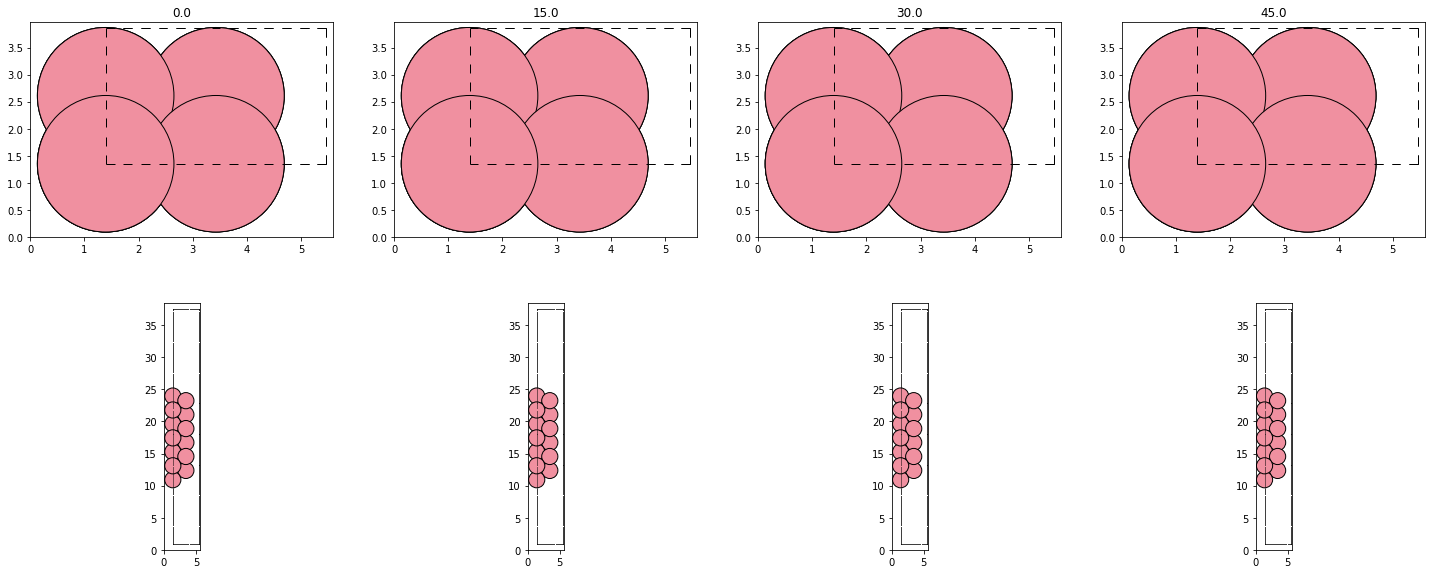

In [12]:
tl.plotcases(notyetrotated, angs)

First, only scale the Zr slabs: 

In [13]:
scaled_rotated = [tl.scalecell(thisatoms, ZrO2001Oterm_2x2.cell.copy()) for thisatoms in notyetrotated]

And finally do the rotations:

In [14]:
dotherotations =  [thiscaled.rotate(ang,'z') for thiscaled, ang in zip(scaled_rotated, angs)]

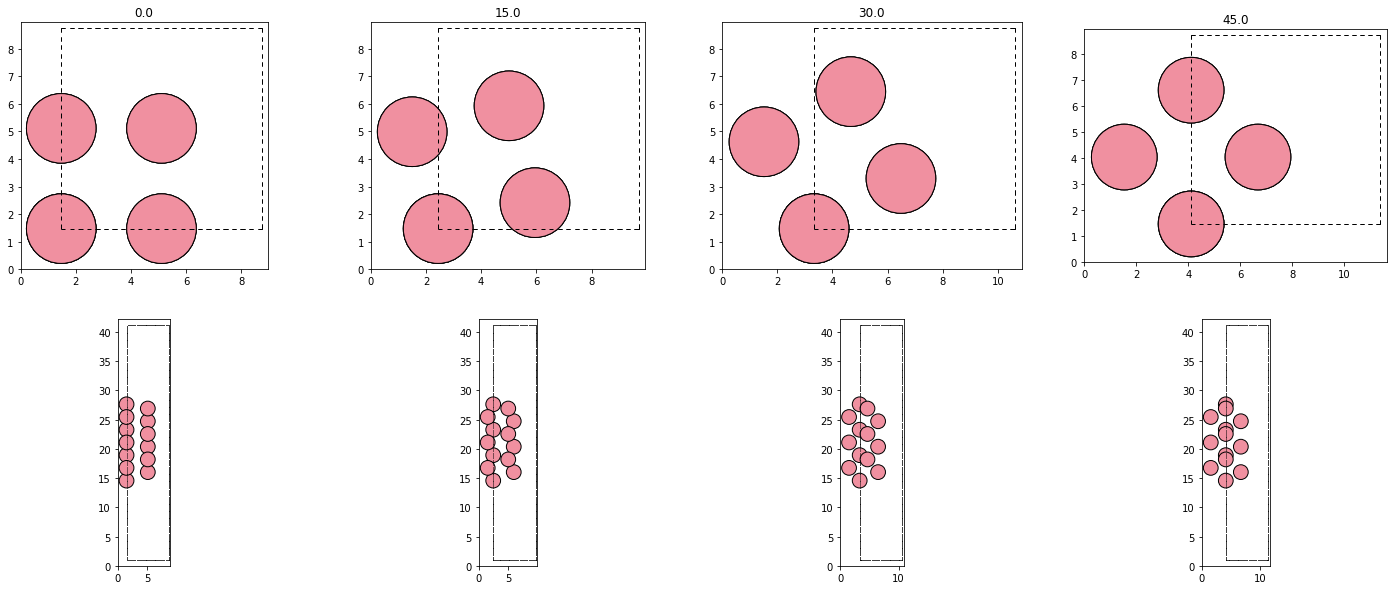

In [15]:
tl.plotcases(scaled_rotated,angs)

# Make the sites on Zr surface 

In [16]:
getsites = [tl.get_adsite(this,face='bottom', site='top') for this in scaled_rotated]

# Make the Stacks

interfacial distance:

In [17]:
d = 2.5 

# stacks: 

In [18]:
allthestacks = [tl.stack(ZrO2001Oterm_2x2, thescalrot, sitio, 'top', 2.5) for thescalrot in scaled_rotated]
wraptem = [thestack.wrap(pretty_translation = True) for thestack in allthestacks]

write the stacks

In [19]:
parentlocation = 'interfaces_febrero22'
if not os.path.exists(parentlocation):
    os.makedirs(parentlocation)
for stack, ang in zip(allthestacks, angs):
    name = os.path.join(parentlocation, f'zro2_001_{sitio}_zr_10m10_{Na_zr}x{Nb_zr}_top_d_{d:.3f}_{ang:.3f}_rotated.vasp')
    stack.write(name, direct=True, sort=True)
    stack.write(name.replace('vasp','xyz'),format='xyz')

# Algunas Visualizaciones 

(<Axes:>, <Axes:>, <Axes:>)

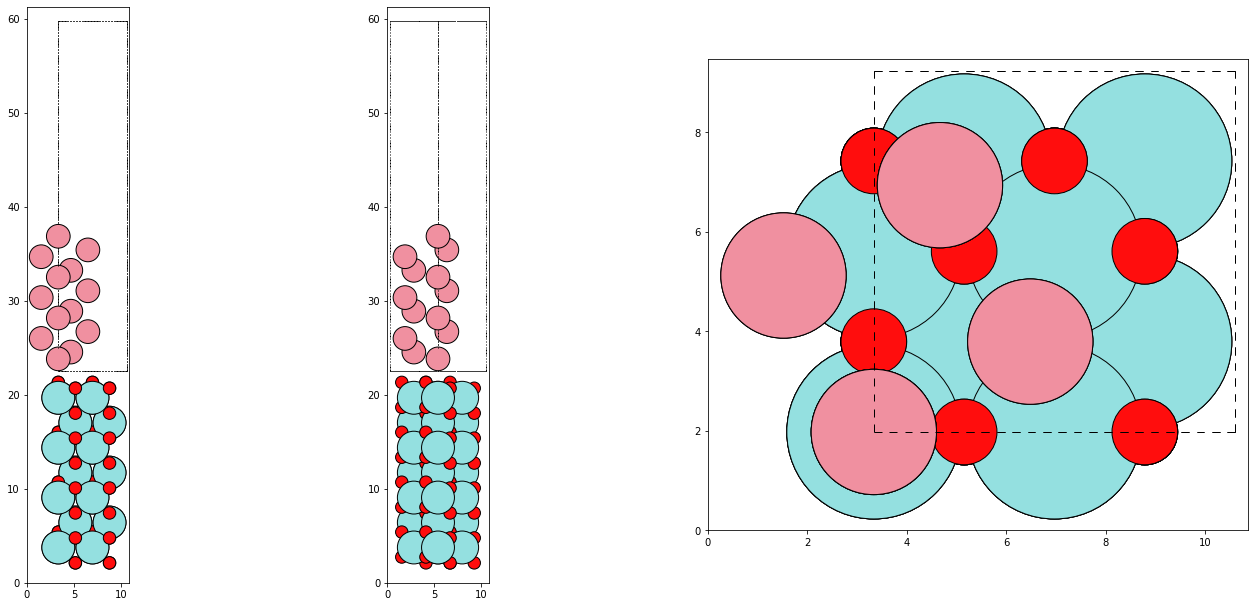

In [20]:
tl.plotviews(allthestacks[2])